In [66]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score## Loading credentials from another config file

## Loading credentials from another config file

In [67]:
import config

## Starting with Spotify API

In [68]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

In [69]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

## Searching the song input by user

In [70]:
user_song = 'Perfect'

In [71]:
results = sp.search(q = user_song, limit = 30, market="GB")
results

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Perfect&type=track&market=GB&offset=0&limit=30',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6eUKZXaKkcviH0Ku9w2n3V'},
       'href': 'https://api.spotify.com/v1/artists/6eUKZXaKkcviH0Ku9w2n3V',
       'id': '6eUKZXaKkcviH0Ku9w2n3V',
       'name': 'Ed Sheeran',
       'type': 'artist',
       'uri': 'spotify:artist:6eUKZXaKkcviH0Ku9w2n3V'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/3T4tUhGYeRNVUGevb0wThu'},
     'href': 'https://api.spotify.com/v1/albums/3T4tUhGYeRNVUGevb0wThu',
     'id': '3T4tUhGYeRNVUGevb0wThu',
     'images': [{'height': 640,
       'url': 'https://i.scdn.co/image/ab67616d0000b273ba5db46f4b838ef6027e6f96',
       'width': 640},
      {'height': 300,
       'url': 'https://i.scdn.co/image/ab67616d00001e02ba5db46f4b838ef6027e6f96',
       'width': 300},
      {'height': 64,
       'url': 'https://i.sc

In [72]:
artist_list = []
for i in range(len(results['tracks']['items'])):
    artist_list.append(results['tracks']['items'][i]['artists'][0]['name'])

In [73]:
artist_list = list(set(artist_list))

In [74]:
artist_list.remove('Ed Sheeran')

In [77]:
# Identify artist
user_song_artist = results['tracks']['items'][0]['artists'][0]['name']

In [78]:
# Identify track ID
user_song_id = results['tracks']['items'][0]['id']

In [79]:
# Get audio features of this song
user_song_features = sp.audio_features(tracks=[user_song_id])

In [80]:
# Save the features in a dataframe
user_song_raw_df = pd.DataFrame(user_song_features)
user_song_df = user_song_raw_df[["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","duration_ms"]]
user_song_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.599,0.448,-6.312,0.0232,0.163,0,0.106,0.168,95.05,263400


## Applying Model

## Doading Dataset

In [81]:
X = pd.read_csv('data/playlists.csv')

In [88]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.733,0.812,-4.634,0.0421,0.02240,0.000962,0.1670,0.409,122.985,39C3SOi6UMD9rHeXAQPNa9,154471
1,0.733,0.855,-4.951,0.0528,0.38800,0.000001,0.1410,0.163,111.958,5cBz1eRdiLpTVcKBZkHnul,166092
2,0.698,0.781,-5.615,0.0401,0.14300,0.000000,0.0762,0.851,124.017,2tX3PY8eP3h9XaBcLXuRBa,166573
3,0.863,0.874,-4.798,0.0884,0.00712,0.087800,0.0455,0.811,125.020,6OHQzBYaXeF6FVu8gxLMkE,144025
4,0.727,0.695,-6.190,0.0518,0.00839,0.000000,0.1100,0.811,127.995,164QjgWOxnSZYHQghRKeC0,193382
...,...,...,...,...,...,...,...,...,...,...,...
3354,0.646,0.464,-9.954,0.4090,0.06950,0.887000,0.1400,0.703,197.399,1uy8jY4k6SmI2Zr6fwbldQ,241306
3355,0.946,0.714,-4.598,0.0999,0.00658,0.076100,0.0590,0.823,113.049,7gWTNLC7MX5L9Ii2Ojggto,324078
3356,0.298,0.968,-4.893,0.0539,0.04810,0.869000,0.2790,0.776,173.540,6d2O45piXdSJ1ieRFuYYXn,222533
3357,0.542,0.915,-3.294,0.1910,0.02150,0.828000,0.2000,0.642,136.020,4wIMg49wp66ned9IZ6QUzf,208385


In [89]:
# Extract numerical cols
X_num = X.select_dtypes(include=['float64', 'int64'])

In [90]:
X_num

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.733,0.812,-4.634,0.0421,0.02240,0.000962,0.1670,0.409,122.985,154471
1,0.733,0.855,-4.951,0.0528,0.38800,0.000001,0.1410,0.163,111.958,166092
2,0.698,0.781,-5.615,0.0401,0.14300,0.000000,0.0762,0.851,124.017,166573
3,0.863,0.874,-4.798,0.0884,0.00712,0.087800,0.0455,0.811,125.020,144025
4,0.727,0.695,-6.190,0.0518,0.00839,0.000000,0.1100,0.811,127.995,193382
...,...,...,...,...,...,...,...,...,...,...
3354,0.646,0.464,-9.954,0.4090,0.06950,0.887000,0.1400,0.703,197.399,241306
3355,0.946,0.714,-4.598,0.0999,0.00658,0.076100,0.0590,0.823,113.049,324078
3356,0.298,0.968,-4.893,0.0539,0.04810,0.869000,0.2790,0.776,173.540,222533
3357,0.542,0.915,-3.294,0.1910,0.02150,0.828000,0.2000,0.642,136.020,208385


## Scaling features

In [91]:
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled_df = pd.DataFrame(X_scaled, columns = X_num.columns)
display(X_num.head())
print()
display(X_scaled_df.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.733,0.812,-4.634,0.0421,0.02240,0.000962,0.1670,0.409,122.985,154471
1,0.733,0.855,-4.951,0.0528,0.38800,0.000001,0.1410,0.163,111.958,166092
2,0.698,0.781,-5.615,0.0401,0.14300,0.000000,0.0762,0.851,124.017,166573
3,0.863,0.874,-4.798,0.0884,0.00712,0.087800,0.0455,0.811,125.020,144025
4,0.727,0.695,-6.190,0.0518,0.00839,0.000000,0.1100,0.811,127.995,193382


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1.045875,0.717572,0.744600,-0.494980,-0.789595,-0.560579,-0.105488,-0.336307,0.092415,-0.760708
1,1.045875,0.877949,0.689699,-0.361033,0.294857,-0.563467,-0.278088,-1.272220,-0.261025,-0.652133
2,0.849913,0.601951,0.574701,-0.520017,-0.431868,-0.563470,-0.708261,1.345291,0.125492,-0.647639
3,1.773731,0.948813,0.716197,0.084623,-0.834919,-0.299609,-0.912062,1.193110,0.157641,-0.858305
4,1.012281,0.281197,0.475117,-0.373551,-0.831152,-0.563470,-0.483881,1.193110,0.252996,-0.397162


# Clustering the tracks with K-Means

In [92]:
kmeans = KMeans(n_clusters = 8, random_state = 1234)
kmeans.fit(X_scaled_df)

KMeans(random_state=1234)

In [93]:
kmeans.labels_

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

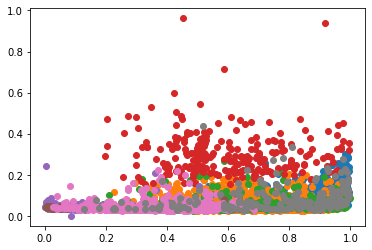

In [94]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(X.to_numpy()[row_ix, 1], X.to_numpy()[row_ix, 3])
# show the plot
pyplot.show()

## Identify Cluster of User's Song

In [95]:
# Scale features of user song
user_scaled = scaler.transform(user_song_df)
user_scaled_df = pd.DataFrame(user_scaled, columns = user_song_df.columns)
user_scaled_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.295622,-0.64004,0.453987,-0.731578,-0.372544,-0.56347,-0.510434,-1.253197,-0.802963,0.257015


In [96]:
# Get the cluster label of user song
user_cluster = kmeans.predict(user_scaled_df)

user_cluster_num = user_cluster[0]

## Choosing a Song from the Identified Cluster

In [97]:
X_clustered = pd.read_csv('data/playlists_clustered.csv')

In [98]:
X_clustered

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,cluster
0,0.733,0.812,-4.634,0.0421,0.02240,0.000962,0.1670,0.409,122.985,39C3SOi6UMD9rHeXAQPNa9,154471,1
1,0.733,0.855,-4.951,0.0528,0.38800,0.000001,0.1410,0.163,111.958,5cBz1eRdiLpTVcKBZkHnul,166092,1
2,0.698,0.781,-5.615,0.0401,0.14300,0.000000,0.0762,0.851,124.017,2tX3PY8eP3h9XaBcLXuRBa,166573,1
3,0.863,0.874,-4.798,0.0884,0.00712,0.087800,0.0455,0.811,125.020,6OHQzBYaXeF6FVu8gxLMkE,144025,1
4,0.727,0.695,-6.190,0.0518,0.00839,0.000000,0.1100,0.811,127.995,164QjgWOxnSZYHQghRKeC0,193382,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3354,0.646,0.464,-9.954,0.4090,0.06950,0.887000,0.1400,0.703,197.399,1uy8jY4k6SmI2Zr6fwbldQ,241306,3
3355,0.946,0.714,-4.598,0.0999,0.00658,0.076100,0.0590,0.823,113.049,7gWTNLC7MX5L9Ii2Ojggto,324078,1
3356,0.298,0.968,-4.893,0.0539,0.04810,0.869000,0.2790,0.776,173.540,6d2O45piXdSJ1ieRFuYYXn,222533,2
3357,0.542,0.915,-3.294,0.1910,0.02150,0.828000,0.2000,0.642,136.020,4wIMg49wp66ned9IZ6QUzf,208385,2


In [99]:
import random
# Filter out rows where cluster == user_cluster_num
rec_df = X_clustered[X_clustered['cluster'] == user_cluster_num]

In [100]:
rec_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,cluster
57,0.487,0.404,-6.039,0.0283,0.950000,0.000009,0.1270,0.2340,78.023,3B9MsMfLlrJGlASQWC9p1c,266581,6
66,0.391,0.375,-12.573,0.0460,0.079700,0.013000,0.1430,0.1160,153.802,0VV8wkOM4w78A2OHZOTzNP,192773,6
67,0.332,0.214,-12.518,0.0349,0.845000,0.000006,0.0839,0.1100,67.531,4eHbdreAnSOrDDsFfc4Fpm,271093,6
75,0.678,0.357,-14.712,0.1280,0.675000,0.005690,0.1240,0.0661,113.301,5eCkuGPZNl4mISFNPgr3Dd,197773,6
82,0.558,0.455,-7.337,0.0382,0.499000,0.000000,0.0992,0.3160,160.096,4AQ3WZrtQkU1TCFrt61cNV,182594,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2623,0.684,0.349,-10.752,0.0311,0.897000,0.000000,0.2780,0.8820,105.316,0RR5ogfmCy25MTo95n5kLA,139762,6
2624,0.411,0.487,-9.115,0.0329,0.770000,0.056900,0.3450,0.8340,177.459,38UmswDbJCKoyx4Dbi0zeO,172973,6
2877,0.287,0.457,-10.549,0.0329,0.013800,0.000000,0.0628,0.1400,60.000,67K49HkE65iIqHQy2FFUE2,236253,6
3030,0.511,0.499,-10.187,0.0588,0.000422,0.015000,0.3000,0.2290,83.680,4e7SS7u3ejEiQsbY7X59n1,166022,6


In [101]:
import random
# Randomly select one row from the filtered DataFrame
rec_row = rec_df.sample(random_state=1)

In [102]:
rec_id = X_clustered[X_clustered['cluster'] == user_cluster_num].sample()['id'].values[0]
rec_id

'6ogtCC5bIU0ScEoQCitZjD'

## Embeded track player

{'spotify': https://open.spotify.com/track/4O2N861eOnF9q8EtpH8IJu

In [103]:
from IPython.display import IFrame

def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

## Incoperating the Inputting Function

In [104]:
%pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from IPython.display import IFrame

Note: you may need to restart the kernel to use updated packages.


### Preparing the Dataframe for the Billboard 100 List

In [105]:
# Import the dataframe of Billboard 100
hot = pd.read_csv('data/billboards_100.csv')

In [106]:
hot

,song,artist
0,Flowers,Miley Cyrus
1,Kill Bill,SZA
2,Last Night,Morgan Wallen
3,Unholy,Sam Smith & Kim Petras
4,Creepin',"Metro Boomin, The Weeknd & 21 Savage"
...,...,...
95,Yandel 150,Yandel & Feid
96,Heart To Heart,Mac DeMarco
97,Next Thing You Know,Jordan Davis
98,Never Gonna Not Dance Again,P!nk


In [107]:
# Assign each artist to a seperate column 
hot_split = hot.rename(columns = {'artist': 'artist_1'})
hot_split = hot_split.assign(artist_2=hot_split['artist_1'].str.split(',| & | With | Featuring | x | X ', expand=True)[1],
                             artist_3=hot_split['artist_1'].str.split(',| & | With | Featuring | x | X ', expand=True)[2])
hot_split['artist_1'] = hot_split['artist_1'].str.split(',| & | With | Featuring | x | X ', expand=True).iloc[:, 0]


In [108]:
hot_split

,song,artist_1,artist_2,artist_3
0,Flowers,Miley Cyrus,None,None
1,Kill Bill,SZA,None,None
2,Last Night,Morgan Wallen,None,None
3,Unholy,Sam Smith,Kim Petras,None
4,Creepin',Metro Boomin,The Weeknd,21 Savage
...,...,...,...,...
95,Yandel 150,Yandel,Feid,None
96,Heart To Heart,Mac DeMarco,None,None
97,Next Thing You Know,Jordan Davis,None,None
98,Never Gonna Not Dance Again,P!nk,None,None


In [109]:
# Define a function to find the ID of a song by song and artist
def find_track_id(song, artist):
    results = sp.search(q = song, limit = 30, market="GB")
    for i in range(len(results['tracks']['items'])):
        if results['tracks']['items'][i]['artists'][0]['name'] == artist:
            track_id = results["tracks"]["items"][i]["id"]
    return track_id

In [110]:
# Define a function to find the first ID of a song only by song
def find_track_id_first(song):
    results = sp.search(q = song, limit = 1, market="GB")
    track_id = results["tracks"]["items"][0]["id"]
    return track_id

In [111]:
# Define a function to find the name of a song via track ID
def find_track_name(track_id):
    track = sp.track(track_id)
    track_name = track['name']
    return track_name

In [112]:
sp.search(q = "Fin de Semana", limit = 10, market="GB")

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Fin+de+Semana&type=track&market=GB&offset=0&limit=10',
  'items': [{'album': {'album_type': 'single',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3l9G1G9MxH6DaRhwLklaf5'},
       'href': 'https://api.spotify.com/v1/artists/3l9G1G9MxH6DaRhwLklaf5',
       'id': '3l9G1G9MxH6DaRhwLklaf5',
       'name': 'Oscar Maydon',
       'type': 'artist',
       'uri': 'spotify:artist:3l9G1G9MxH6DaRhwLklaf5'},
      {'external_urls': {'spotify': 'https://open.spotify.com/artist/7Gi6gjaWy3DxyilpF1a8Is'},
       'href': 'https://api.spotify.com/v1/artists/7Gi6gjaWy3DxyilpF1a8Is',
       'id': '7Gi6gjaWy3DxyilpF1a8Is',
       'name': 'Junior H',
       'type': 'artist',
       'uri': 'spotify:artist:7Gi6gjaWy3DxyilpF1a8Is'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/366AAoKCXunrJSqKqZuafy'},
     'href': 'https://api.spotify.com/v1/albums/366AAoKCXunrJSqKqZuafy',
     'id': '366AAoKC

In [113]:
# Define a function to find the artist of a song via track ID
def find_track_artist(track_id):
    track = sp.track(track_id)
    artist_name = track['artists'][0]['name']
    return artist_name

In [114]:
# for i in range(len(results['tracks']['items'])):
#     if results['tracks']['items'][i]['artists'][0]['name'] == 'Ed Sheeran':
#         track_id = results["tracks"]["items"][i]["id"]

In [115]:
# Define a function to save the sound features of a song to a dataframe
def get_sound_features(track_id):
    features = sp.audio_features(tracks=[track_id])
    feature_df = pd.DataFrame(features)
    feature_df = feature_df[["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","duration_ms"]]
    return feature_df

In [116]:
# Define a function to predict the cluster label of a song
def cluster_label(features_df):
    scaler = StandardScaler()
    scaler.fit(X_num)
    features_scaled = scaler.transform(features_df)
    features_scaled_df = pd.DataFrame(features_scaled, columns = features_df.columns)
    cluster_num = kmeans.predict(features_scaled_df)[0]
    return cluster_num

In [117]:
# Define a function to get the ID of the song ramdonly chosen from the specific cluster
def rec_sample_id(cluster_num):
    rec_df = X_clustered[X_clustered['cluster'] == cluster_num]
    rec_id = rec_df.sample()['id'].values[0]
    return rec_id

In [118]:
# Define a function to list out the other possible artists for the input song 
def other_artists(song, selected_artist):
    results = sp.search(q = song, limit = 30, market="GB")
    artist_list = []
    for i in range(len(results['tracks']['items'])):
        artist_list.append(results['tracks']['items'][i]['artists'][0]['name'])
    artist_list = list(set(artist_list)) # remove duplicates
    artist_list.remove(selected_artist)
    return artist_list

In [119]:
# Define a function to print a list with an ordinal number before each artist

def list_with_number(artist_list):    
    artist_list_string = ''
    for i, artist in enumerate(artist_list):
        artist_list_string += f"{i+1}. {artist}, "

    artist_list_string = artist_list_string[:-2] # Remove the final comma and space
    return artist_list_string

In [120]:
def track_artist_pair(song):
    results = sp.search(q=song, limit=30, market="GB")

    track_artist = []
    for i in range(len(results['tracks']['items'])):
        artist = results['tracks']['items'][i]['artists'][0]['name']
        track = results['tracks']['items'][i]['name']
        # pair tracks and artists with dash
        pair = f"{track} - {artist}"
        # make sure there is no dupilicates
        if pair not in track_artist:
            track_artist.append(pair)
    # add order number for each pair
    track_artist_numbered = [f"{i+1}. {pair}" for i, pair in enumerate(track_artist)]

    return track_artist_numbered


In [121]:
# Define a function to search a song name Spotify and list song names and artist names as pairs
def track_artist_pair(song):
    results = sp.search(q = song, limit = 10, market = "GB")

    artist_list = []
    track_list = []

    for i in range(len(results['tracks']['items'])):
        artist = results['tracks']['items'][i]['artists'][0]['name']
        track = results['tracks']['items'][i]['name']
        
        # check if track artist pair has already been added
        if f"{track} - {artist}" not in track_list:
            artist_list.append(artist)
            track_list.append(track)

    # create list of track artist pairs with order number
    track_artist = [f"{i+1}. {x} - {y}" for i, (x, y) in enumerate(zip(track_list, artist_list))]

    return track_artist, artist_list, track_list


In [122]:
track_artist_1, artist_list_1, track_list_1 = track_artist_pair("Lemon Tree")

In [123]:
artist_list = ['Mundo Suave', 'Ghost and Pals', 'The Beautiful South', 'Mason', 'Sam Smith', 'Mareux', 'Jonas Blue', 'Lou Reed', 'beabadoobee', 'SlowFez', 'One Direction', 'White Noise Baby Sleep', 'Cousin Stizz', 'Powell Sullivan']
print(f'No problem! Is the song performed by one of the following artists: {list_with_number(artist_list)}? (Y/N)')

No problem! Is the song performed by one of the following artists: 1. Mundo Suave, 2. Ghost and Pals, 3. The Beautiful South, 4. Mason, 5. Sam Smith, 6. Mareux, 7. Jonas Blue, 8. Lou Reed, 9. beabadoobee, 10. SlowFez, 11. One Direction, 12. White Noise Baby Sleep, 13. Cousin Stizz, 14. Powell Sullivan? (Y/N)


In [124]:
artist_list

['Mundo Suave',
 'Ghost and Pals',
 'The Beautiful South',
 'Mason',
 'Sam Smith',
 'Mareux',
 'Jonas Blue',
 'Lou Reed',
 'beabadoobee',
 'SlowFez',
 'One Direction',
 'White Noise Baby Sleep',
 'Cousin Stizz',
 'Powell Sullivan']

In [125]:
# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a hot song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_song.lower(), 'artist'][0]
#             comfirm = input(f'Do you mean "{input_song}" performed by "{check_singer}"? (Y/N) ')
#             if comfirm.lower() == 'y':
#                 print(f'Got it! Playing "{input_song}"!')
#                 play_song(find_track_id(input_song)) # Play the song
#                 break
#             else:
#                 rec_hot = random.sample(hot.song.tolist(), k=5)
#                 print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')
#         else:
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [126]:
# # Update find_track_id() (two arguemnets)

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a hot song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_song.lower(), 'artist'][0]
#             comfirm = input(f'Do you mean "{input_song}" performed by "{check_singer}"? (Y/N) ')
#             if comfirm.lower() == 'y':
#                 print(f'Got it! Playing "{input_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_song, check_singer))) # Play the song
#                 break
#             else:
#                 rec_hot = random.sample(hot.song.tolist(), k=1)
#                 print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')
#         else:
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [127]:
# # Recommend another hot song and play it

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a hot song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_song.lower(), 'artist'][0]
#             comfirm = input(f'Do you mean "{input_song}" performed by "{check_singer}"? (Y/N) ')
            
#             if comfirm.lower() == 'y':
#                 print(f'Got it! Playing "{input_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_song, check_singer))) # Play the song
                
#                 # Recommend another hot song and play it
#                 rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                 rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
#                 if rec_hot_request.lower() == 'y':
#                     rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                     print(f'Wonderful! Playing "{rec_hot}" performed by "{rec_hot_singer}"!')
#                     display(play_song(find_track_id(rec_hot, rec_hot_singer)))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
#                 else:
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                            
#             else:
#                 rec_hot = random.sample(hot.song.tolist(), k=1)
#                 print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')
#         else:
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [128]:
# # Feature: Recommend another song depending on the audio features      
# # Sub-Feature: Let user to choose a possible artist and play it accordingly

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'][0]
#             comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N) ')
            
#             if comfirm_hot_artist.lower() == 'y':
#                 print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_hot_song, check_singer))) # Play the song
                
#                 # Recommend another hot song and play it
#                 rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                 rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
#                 if rec_hot_request.lower() == 'y':
#                     rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                     print(f'Wonderful! Playing "{rec_hot}" performed by "{rec_hot_singer}"!')
#                     display(play_song(find_track_id(rec_hot, rec_hot_singer)))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                    
#             # Recommend another song depending on the audio features        
#             elif comfirm_hot_artist.lower() == 'n':
#                 # Let user to choose a possible artist and play it accordingly
#                 other_artists_list = other_artists(input_song, check_singer)
#                 print(f'No problem! Is the song performed by one of the following artists: {list_with_number(other_artists_list)}?')
#                 choose_artist = input(f'If the artist is listed, please input the number to choose; otherwise please input "N".')
#                 if choose_artist.lower() == 'n':
#                     print(f'I am sorry, the song you entered might not be found.')
#                     continue
#                 elif choose_artist.isdigit() and int(choose_artist) in range(1, len(other_artists_list)):
#                     chosen_artist = other_artists_list[int(choose_artist) - 1]
#                     print(f'Got it! Playing "{find_track_name(input_song, chosen_artist)}" performed by "{chosen_artist}".')
#                     display(play_song(find_track_id(input_song, chosen_artist)))
                    
#                 else: 
#                     print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
#                     # Loose end!!! This won't send user back to 'choose_artist' input
                
#             else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#         else:
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [129]:
# # Feature: Recommend another song depending on the audio features of the song whose name is same with one in the hot list     
# # Sub-Feature: Ask user if want to listen another song

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'][0]
#             comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N) ')
            
#             if comfirm_hot_artist.lower() == 'y':
#                 print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_hot_song, check_singer))) # Play the song
                
#                 # Recommend another hot song and play it
#                 rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                 rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
#                 if rec_hot_request.lower() == 'y':
#                     rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                     print(f'Wonderful! Playing "{rec_hot}" performed by "{rec_hot_singer}"!')
#                     display(play_song(find_track_id(rec_hot, rec_hot_singer)))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                    
#             # Recommend another song depending on the audio features        
#             elif comfirm_hot_artist.lower() == 'n':
#                 # Let user to choose a possible artist and play it accordingly
#                 other_artists_list = other_artists(input_song, check_singer)
#                 print(f'No problem! Is the song performed by one of the following artists: {list_with_number(other_artists_list)}?')
#                 choose_artist = input(f'If the artist is listed, please input the number to choose; otherwise please input "N".')
#                 if choose_artist.lower() == 'n':
#                     print(f'I am sorry, the song you entered might not be found.')
#                     continue
#                 elif choose_artist.isdigit() and int(choose_artist) in range(1, len(other_artists_list)):
#                     chosen_artist = other_artists_list[int(choose_artist) - 1]
#                     chosen_track_id = find_track_id(input_song, chosen_artist)
#                     chosen_track_name = find_track_name(chosen_track_id)
#                     print(f'Got it! Playing "{chosen_track_name}" performed by "{chosen_artist}".')
#                     display(play_song(chosen_track_id))
                    
#                     # Ask user if want to listen another song
#                     rec_other_request = input(f'Would you like to try another song like this one: "{chosen_track_name}"? (Y/N)')
                    
#                     if rec_other_request.lower() == 'y':
#                         chosen_track_features_df = get_sound_features(chosen_track_id)
#                         chosen_track_label = cluster_label(chosen_track_features_df)
#                         rec_other_id = rec_sample_id(chosen_track_label)
#                         rec_other_name = find_track_name(rec_other_id)
#                         rec_other_artist = find_track_artist(rec_other_id)

#                         print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                         display(play_song(rec_other_id))
#                         print(f'Thank you for using GrooveGenie!')
#                         break
#                     elif rec_hot_request.lower() == 'n':
#                         print(f'No problem! Thank you for using GrooveGenie!')
#                         break
#                     else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')

#                 else: 
#                     print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
#                     # Loose end!!! This won't send user back to 'choose_artist' input
                
#             else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#         else:
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [130]:
# # Feature: Play the input song out of the hot list     

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'][0]
#             comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N) ')
            
#             if comfirm_hot_artist.lower() == 'y':
#                 print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_hot_song, check_singer))) # Play the song
                
#                 # Recommend another hot song and play it
#                 rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                 rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
#                 if rec_hot_request.lower() == 'y':
#                     rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                     print(f'Wonderful! Playing "{rec_hot}" performed by "{rec_hot_singer}"!')
#                     display(play_song(find_track_id(rec_hot, rec_hot_singer)))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                    
#             # Recommend another song depending on the audio features        
#             elif comfirm_hot_artist.lower() == 'n':
#                 # Let user to choose a possible artist and play it accordingly
#                 other_artists_list = other_artists(input_song, check_singer)
#                 print(f'No problem! Is the song performed by one of the following artists: {list_with_number(other_artists_list)}?')
#                 choose_artist = input(f'If the artist is listed, please input the number to choose; otherwise please input "N".')
#                 if choose_artist.lower() == 'n':
#                     print(f'I am sorry, the song you entered might not be found.')
#                     continue
#                 elif choose_artist.isdigit() and int(choose_artist) in range(1, len(other_artists_list)):
#                     chosen_artist = other_artists_list[int(choose_artist) - 1]
#                     chosen_track_id = find_track_id(input_song, chosen_artist)
#                     chosen_track_name = find_track_name(chosen_track_id)
#                     print(f'Got it! Playing "{chosen_track_name}" performed by "{chosen_artist}".')
#                     display(play_song(chosen_track_id))
                    
#                     # Ask user if want to listen another song
#                     rec_other_request = input(f'Would you like to try another song like this one: "{chosen_track_name}"? (Y/N)')
                    
#                     if rec_other_request.lower() == 'y':
#                         chosen_track_features_df = get_sound_features(chosen_track_id)
#                         chosen_track_label = cluster_label(chosen_track_features_df)
#                         rec_other_id = rec_sample_id(chosen_track_label)
#                         rec_other_name = find_track_name(rec_other_id)
#                         rec_other_artist = find_track_artist(rec_other_id)

#                         print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                         display(play_song(rec_other_id))
#                         print(f'Thank you for using GrooveGenie!')
#                         break
#                     elif rec_hot_request.lower() == 'n':
#                         print(f'No problem! Thank you for using GrooveGenie!')
#                         break
#                     else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')

#                 else: 
#                     print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
#                     # Loose end!!! This won't send user back to 'choose_artist' input
                
#             else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#         else:
#             # Play the input song out of the hot list
#             input_track_id = find_track_id_first(input_song)
#             input_track_name = find_track_name(input_track_id)
#             input_track_artist = find_track_artist(input_track_id)
#             print(f'Got it! Playing "{input_track_name}" performed by "{input_track_artist}".')
#             display(play_song(input_track_id))
            
            
#             rec_hot = random.sample(hot.song.tolist(), k=5)
#             print(f'Sorry, this is not a hot song. Would you like to try one of these hot songs? {rec_hot}')

In [131]:
# # Feature: Let user to choose the track name and artist    

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'].iloc[0]
#             comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N) ')
            
#             if comfirm_hot_artist.lower() == 'y':
#                 print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_hot_song, check_singer))) # Play the song
                
#                 # Recommend another hot song and play it
#                 rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                 rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
#                 if rec_hot_request.lower() == 'y':
#                     rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                     print(f'Wonderful! Playing "{rec_hot}" performed by "{rec_hot_singer}"!')
#                     rec_hot_track_id = find_track_id(rec_hot, rec_hot_singer)
#                     display(play_song(rec_hot_track_id))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                    
#             # Recommend another song depending on the audio features        
#             elif comfirm_hot_artist.lower() == 'n':
#                 # Let user to choose a possible artist and play it accordingly
                
#                 comfirm_track_artist_list, comfirm_artist_list, comfirm_track_list = track_artist_pair(input_song)
                
#                 print(f'Got it! Here is the search result: {comfirm_track_artist_list}')
#                 precise_track = input(f'Please input the number to choose the song you want to listen. To exit please input "X".')
                
#                 if precise_track.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                    
#                 elif precise_track.isdigit() and int(precise_track) in range(1, len(comfirm_track_artist_list)):
#                     comfirm_artist = comfirm_artist_list[int(precise_track) - 1]
#                     comfirm_track_name = comfirm_track_list[int(precise_track) - 1]
#                     comfirm_track_id = find_track_id(comfirm_track_name, comfirm_artist)
#                     print(f'Got it! Playing "{comfirm_track_name}" performed by "{comfirm_artist}".')
#                     display(play_song(comfirm_track_id))
                    
#                     # Ask user if want to listen another song
#                     rec_other_request = input(f'Would you like to try another song like this one: "{comfirm_track_name}"? (Y/N)')
                    
#                     if rec_other_request.lower() == 'y':
#                         chosen_track_features_df = get_sound_features(comfirm_track_id)
#                         chosen_track_label = cluster_label(chosen_track_features_df)
#                         rec_other_id = rec_sample_id(chosen_track_label)
#                         rec_other_name = find_track_name(rec_other_id)
#                         rec_other_artist = find_track_artist(rec_other_id)

#                         print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                         display(play_song(rec_other_id))
#                         print(f'Thank you for using GrooveGenie!')
#                         break
#                     elif rec_hot_request.lower() == 'n':
#                         print(f'No problem! Thank you for using GrooveGenie!')
#                         break
#                     else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')

#                 else: 
#                     print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
#                     # Loose end!!! This won't send user back to 'choose_artist' input
                
#             else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#         else:
#             # Let user to choose the track name and artist
#             track_artist_list, artist_list, track_list = track_artist_pair(input_song)
#             print(f'Got it! Here is the search result: {track_artist_list}')
#             precise_track = input(f'Please input the number to choose the song you want to listen. To exit please input "X".')
            
#             if precise_track.isdigit() and int(precise_track) in range(1, len(track_artist_list)):
#                 precise_artist = artist_list[int(precise_track) - 1]
#                 precise_track_name = track_list[int(precise_track) - 1]
#                 precise_track_id = find_track_id(precise_track_name, precise_artist)
#                 print(f'Got it! Playing "{precise_track}" performed by "{precise_artist}".')
#                 display(play_song(precise_track_id))            
#             elif precise_track.lower() == 'x':
#                 print(f'Thank you for using GrooveGenie!')
#                 break
#             else:
#                 print(f'Please enter a number between 1 and {len(track_artist_list)} or letter "X" (for "Exit").')

In [132]:
# # Feature: Recommend another song depending on the audio features of the song out of the hot list    

# def GrooveGenie():
#     while True:
#         input_song = input('Please enter a song: ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
#         if max_ratio >= 70:
#             input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'].iloc[0]
#             comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N) ')
            
#             if comfirm_hot_artist.lower() == 'y':
#                 print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
#                 display(play_song(find_track_id(input_hot_song, check_singer))) # Play the song
                
#                 # Recommend another hot song and play it
#                 rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                 rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
#                 if rec_hot_request.lower() == 'y':
#                     rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                     print(f'Wonderful! Playing "{rec_hot}" performed by "{rec_hot_singer}"!')
#                     rec_hot_track_id = find_track_id(rec_hot, rec_hot_singer)
#                     display(play_song(rec_hot_track_id))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                    
#             # Recommend another song depending on the audio features        
#             elif comfirm_hot_artist.lower() == 'n':
#                 # Let user to choose a possible artist and play it accordingly
                
#                 comfirm_track_artist_list, comfirm_artist_list, comfirm_track_list = track_artist_pair(input_song)
                
#                 print(f'Got it! Here is the search result: {comfirm_track_artist_list}')
#                 precise_track = input(f'Please input the number to choose the song you want to listen. To exit please input "X".')
                
#                 if precise_track.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                    
#                 elif precise_track.isdigit() and int(precise_track) in range(1, len(comfirm_track_artist_list)):
#                     comfirm_artist = comfirm_artist_list[int(precise_track) - 1]
#                     comfirm_track_name = comfirm_track_list[int(precise_track) - 1]
#                     comfirm_track_id = find_track_id(comfirm_track_name, comfirm_artist)
#                     print(f'Got it! Playing "{comfirm_track_name}" performed by "{comfirm_artist}".')
#                     display(play_song(comfirm_track_id))
                    
#                     # Recommend another song alike
#                     rec_other_request = input(f'Would you like to try another song like this one: "{comfirm_track_name}"? (Y/N)')
                    
#                     if rec_other_request.lower() == 'y':
#                         chosen_track_features_df = get_sound_features(comfirm_track_id)
#                         chosen_track_label = cluster_label(chosen_track_features_df)
#                         rec_other_id = rec_sample_id(chosen_track_label)
#                         rec_other_name = find_track_name(rec_other_id)
#                         rec_other_artist = find_track_artist(rec_other_id)

#                         print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                         display(play_song(rec_other_id))
#                         print(f'Thank you for using GrooveGenie!')
#                         break
                        
#                     elif rec_hot_request.lower() == 'n':
#                         print(f'No problem! Thank you for using GrooveGenie!')
#                         break
                        
#                     else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')

#                 else: 
#                     print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
#                     # Loose end!!! This won't send user back to 'choose_artist' input
                
#             else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#         else:
#             # Let user to choose the track name and artist
#             track_artist_list, artist_list, track_list = track_artist_pair(input_song)
#             print(f'Got it! Here is the search result: {track_artist_list}')
#             precise_track = input(f'Please input the number to choose the song you want to listen. To exit please input "X".')
            
#             if precise_track.isdigit() and int(precise_track) in range(1, len(track_artist_list)):
#                 precise_artist = artist_list[int(precise_track) - 1]
#                 precise_track_name = track_list[int(precise_track) - 1]
#                 precise_track_id = find_track_id(precise_track_name, precise_artist)
#                 print(f'Got it! Playing "{precise_track}" performed by "{precise_artist}".')
#                 display(play_song(precise_track_id)) 
                
#                 # Recommend another song alike
#                 rec_other_request = input(f'Would you like to try another song like this one: "{precise_track_name}"? (Y/N)')
                
#                 if rec_other_request.lower() == 'y':
#                     chosen_track_features_df = get_sound_features(precise_track_id)
#                     chosen_track_label = cluster_label(chosen_track_features_df)
#                     rec_other_id = rec_sample_id(chosen_track_label)
#                     rec_other_name = find_track_name(rec_other_id)
#                     rec_other_artist = find_track_artist(rec_other_id)

#                     print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                     display(play_song(rec_other_id))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                    
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
                    
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')                
                
#             elif precise_track.lower() == 'x':
#                 print(f'Thank you for using GrooveGenie!')
#                 break
#             else:
#                 print(f'Please enter a number between 1 and {len(track_artist_list)} or letter "X" (for "Exit").')

In [133]:
# # Feature: Give user an opition to exit in every input    

# def GrooveGenie():
#     while True:
#         input_song = input('Welcome to GrooveGenie! Please enter a song (Note: to exit please always enter "X"): ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
        
#         if input_song.lower() == 'x':
#             print(f'Thank you for using GrooveGenie!')
#             break
            
#         elif max_ratio >= 80:
#             input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'].iloc[0]
#             comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N)')
            
#             if comfirm_hot_artist.lower() == 'x':
#                 print(f'Thank you for using GrooveGenie!')
#                 break
                
#             elif comfirm_hot_artist.lower() == 'y':
#                 print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
#                 input_hot_song_id = find_track_id_first(input_hot_song)
#                 display(play_song(input_hot_song_id)) # Play the song
                
#                 # Recommend another hot song and play it
#                 rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                 rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')
                
#                 if rec_hot_request.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break                
                
#                 elif rec_hot_request.lower() == 'y':
#                     # rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                     print(f'Wonderful! Playing "{rec_hot}"!')
                    
#                     rec_hot_track_id = find_track_id_first(rec_hot)
#                     display(play_song(rec_hot_track_id))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                    
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
                    
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                    
#             # Recommend another song depending on the audio features        
#             elif comfirm_hot_artist.lower() == 'n':
#                 # Let user to choose a possible artist and play it accordingly
                
#                 comfirm_track_artist_list, comfirm_artist_list, comfirm_track_list = track_artist_pair(input_song)
                
#                 # display each item in a separate line
#                 comfirm_track_artist_str = '\n'.join(comfirm_track_artist_list)
                
#                 print(f'Got it! Here is the search result: \n{comfirm_track_artist_str}')
#                 precise_track = input(f'Please input the number to choose the song you want to listen.')
                
#                 if precise_track.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                    
#                 elif precise_track.isdigit() and int(precise_track) in range(1, len(comfirm_track_artist_list)):
#                     comfirm_artist = comfirm_artist_list[int(precise_track) - 1]
#                     comfirm_track_name = comfirm_track_list[int(precise_track) - 1]
#                     comfirm_track_id = find_track_id(comfirm_track_name, comfirm_artist)
#                     print(f'Got it! Playing "{comfirm_track_name}" performed by "{comfirm_artist}".')
#                     display(play_song(comfirm_track_id))
                    
#                     # Recommend another song alike
#                     rec_other_request = input(f'Would you like to try another song like this one: "{comfirm_track_name}"? (Y/N)')
                    
#                     if rec_other_request.lower() == 'x':
#                         print(f'Thank you for using GrooveGenie!')
#                         break
                    
#                     elif rec_other_request.lower() == 'y':
#                         chosen_track_features_df = get_sound_features(comfirm_track_id)
#                         chosen_track_label = cluster_label(chosen_track_features_df)
#                         rec_other_id = rec_sample_id(chosen_track_label)
#                         rec_other_name = find_track_name(rec_other_id)
#                         rec_other_artist = find_track_artist(rec_other_id)

#                         print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                         display(play_song(rec_other_id))
#                         print(f'Thank you for using GrooveGenie!')
#                         break
                        
#                     elif rec_hot_request.lower() == 'n':
#                         print(f'No problem! Thank you for using GrooveGenie!')
#                         break
                        
#                     else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')

#                 else: 
#                     print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
#                     # Loose end!!! This won't send user back to 'choose_artist' input
                
#             else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#         else:
#             # Let user to choose the track name and artist
#             track_artist_list, artist_list, track_list = track_artist_pair(input_song)
            
#             # display each item in a separate line
#             track_artist_str = '\n'.join(track_artist_list)
            
#             print(f'Got it! Here is the search result: \n{track_artist_str}')
#             precise_track = input(f'Please input the number to choose the song you want to listen.')
            
#             if precise_track.lower() == 'x':
#                 print(f'Thank you for using GrooveGenie!')
#                 break
                
#             elif precise_track.isdigit() and int(precise_track) in range(1, len(track_artist_list)):
#                 precise_artist = artist_list[int(precise_track) - 1]
#                 precise_track_name = track_list[int(precise_track) - 1]
#                 precise_track_id = find_track_id(precise_track_name, precise_artist)
#                 print(f'Got it! Playing "{precise_track}" performed by "{precise_artist}".')
#                 display(play_song(precise_track_id)) 
                
#                 # Recommend another song alike
#                 rec_other_request = input(f'Would you like to try another song like this one: "{precise_track_name}"? (Y/N)')
            
#                 if rec_other_request.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                
#                 elif rec_other_request.lower() == 'y':
#                     chosen_track_features_df = get_sound_features(precise_track_id)
#                     chosen_track_label = cluster_label(chosen_track_features_df)
#                     rec_other_id = rec_sample_id(chosen_track_label)
#                     rec_other_name = find_track_name(rec_other_id)
#                     rec_other_artist = find_track_artist(rec_other_id)

#                     print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                     display(play_song(rec_other_id))
#                     print(f'Thank you for using GrooveGenie!')
#                     break
                    
#                 elif rec_hot_request.lower() == 'n':
#                     print(f'No problem! Thank you for using GrooveGenie!')
#                     break
                    
#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')                
                
#             elif precise_track.lower() == 'x':
#                 print(f'Thank you for using GrooveGenie!')
#                 break
#             else:
#                 print(f'Please enter a number between 1 and {len(track_artist_list)} or letter "X" (for "Exit").')

In [139]:
# Feature: add while loops to provide the option to request input again if the input is not valid    

def GrooveGenie():
    while True:
        input_song = input('Welcome to GrooveGenie! Please enter a song (Note: to exit please always enter "X"): ')
        match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
        max_ratio = max(match_ratios) # Get the highest matching score
        
        if input_song.lower() == 'x':
            print(f'Thank you for using GrooveGenie!')
            break
            
        elif max_ratio >= 80:
            input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
            check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'].iloc[0]
            while True:
                comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N)')

                if comfirm_hot_artist.lower() == 'x':
                    print(f'Thank you for using GrooveGenie!')
                    break

                elif comfirm_hot_artist.lower() == 'y':
                    print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
                    input_hot_song_id = find_track_id_first(input_hot_song)
                    display(play_song(input_hot_song_id)) # Play the song

                    # Recommend another hot song and play it
                    rec_hot = random.sample(hot.song.tolist(), k=1)[0]
                    while True:
                        rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')

                        if rec_hot_request.lower() == 'x':
                            print(f'Thank you for using GrooveGenie!')
                            break                

                        elif rec_hot_request.lower() == 'y':
                            # rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
                            print(f'Wonderful! Playing "{rec_hot}"!')

                            rec_hot_track_id = find_track_id_first(rec_hot)
                            display(play_song(rec_hot_track_id))
                            print(f'Thank you for using GrooveGenie!')
                            break

                        elif rec_hot_request.lower() == 'n':
                            print(f'No problem! Thank you for using GrooveGenie!')
                            break

                        else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                        break    
                    break

                # Recommend another song depending on the audio features        
                elif comfirm_hot_artist.lower() == 'n':
                    # Let user to choose a possible artist and play it accordingly

                    comfirm_track_artist_list, comfirm_artist_list, comfirm_track_list = track_artist_pair(input_song)

                    # display each item in a separate line
                    comfirm_track_artist_str = '\n'.join(comfirm_track_artist_list)

                    print(f'Got it! Here is the search result: \n{comfirm_track_artist_str}')
                    
                    while True:
                        precise_track = input('Please enter the number to choose the song you want to listen. ')

                        if precise_track.lower() == 'x':
                            print(f'Thank you for using GrooveGenie!')
                            break

                        elif precise_track.isdigit() and int(precise_track) in range(1, len(comfirm_track_artist_list)+1): # +1 because range() is exclusive
                            comfirm_artist = comfirm_artist_list[int(precise_track) - 1]
                            comfirm_track_name = comfirm_track_list[int(precise_track) - 1]
                            comfirm_track_id = find_track_id(comfirm_track_name, comfirm_artist)
                            print(f'Got it! Playing "{comfirm_track_name}" performed by "{comfirm_artist}".')
                            display(play_song(comfirm_track_id))

                            # Recommend another song alike
                            while True:
                                rec_other_request = input(f'Would you like to try another song like this one? (Y/N) ')

                                if rec_other_request.lower() == 'x':
                                    print(f'Thank you for using GrooveGenie!')
                                    break

                                elif rec_other_request.lower() == 'y':
                                    chosen_track_features_df = get_sound_features(comfirm_track_id)
                                    chosen_track_label = cluster_label(chosen_track_features_df)
                                    rec_other_id = rec_sample_id(chosen_track_label)
                                    rec_other_name = find_track_name(rec_other_id)
                                    rec_other_artist = find_track_artist(rec_other_id)

                                    print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
                                    display(play_song(rec_other_id))
                                    print(f'Thank you for using GrooveGenie!')
                                    break

                                elif rec_other_request.lower() == 'n':
                                    print(f'No problem! Thank you for using GrooveGenie!')
                                    break

                                else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                                break
                            break

                        else: 
                            print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
                        break
                    break

                else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                break    
            break
            
        else:
            # Let user to choose the track name and artist
            track_artist_list, artist_list, track_list = track_artist_pair(input_song)
            
            # display each item in a separate line
            track_artist_str = '\n'.join(track_artist_list)
            
            print(f'Got it! Here is the search result: \n{track_artist_str}')
            
            while True:
                precise_track = input(f'Please input the number to choose the song you want to listen.')

                if precise_track.lower() == 'x':
                    print(f'Thank you for using GrooveGenie!')
                    break

                elif precise_track.isdigit() and int(precise_track) in range(1, len(track_artist_list)+1):
                    precise_artist = artist_list[int(precise_track) - 1]
                    precise_track_name = track_list[int(precise_track) - 1]
                    precise_track_id = find_track_id(precise_track_name, precise_artist)
                    print(f'Got it! Playing "{precise_track_name}" performed by "{precise_artist}".')
                    display(play_song(precise_track_id)) 

                    # Recommend another song alike
                    while True:
                        rec_other_request = input(f'Would you like to try another song like this one: "{precise_track_name}"? (Y/N)')

                        if rec_other_request.lower() == 'x':
                            print(f'Thank you for using GrooveGenie!')
                            break

                        elif rec_other_request.lower() == 'y':
                            chosen_track_features_df = get_sound_features(precise_track_id)
                            chosen_track_label = cluster_label(chosen_track_features_df)
                            rec_other_id = rec_sample_id(chosen_track_label)
                            rec_other_name = find_track_name(rec_other_id)
                            rec_other_artist = find_track_artist(rec_other_id)

                            print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
                            display(play_song(rec_other_id))
                            print(f'Thank you for using GrooveGenie!')
                            break

                        elif rec_other_request.lower() == 'n':
                            print(f'No problem! Thank you for using GrooveGenie!')
                            break

                        else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
                        break
                    break

                elif precise_track.lower() == 'x':
                    print(f'Thank you for using GrooveGenie!')
                    break
                else:
                    print(f'Please enter a number between 1 and {len(track_artist_list)} or letter "X" (for "Exit").')
                break
            break

In [135]:
# # Feature: offer the option to search another song at the end of a task   

# def GrooveGenie():
#     while True:
#         input_song = input('Welcome to GrooveGenie! Please enter a song (Note: to exit please always enter "X"): ')
#         match_ratios = [fuzz.token_set_ratio(input_song.lower(), s.lower()) for s in hot.song] # Generate a list of matching scores
#         max_ratio = max(match_ratios) # Get the highest matching score
        
#         if input_song.lower() == 'x':
#             print(f'Thank you for using GrooveGenie!')
#             break
            
#         elif max_ratio >= 80:
#             input_hot_song = hot.song[match_ratios.index(max_ratio)] # Correct the input by the song which matches the input best
#             check_singer = hot.loc[hot.song.str.lower() == input_hot_song.lower(), 'artist'].iloc[0]
#             while True:
#                 comfirm_hot_artist = input(f'Do you mean "{input_hot_song}" performed by "{check_singer}"? (Y/N)')

#                 if comfirm_hot_artist.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break

#                 elif comfirm_hot_artist.lower() == 'y':
#                     print(f'Got it! Playing "{input_hot_song}" performed by "{check_singer}"!')
#                     input_hot_song_id = find_track_id_first(input_hot_song)
#                     display(play_song(input_hot_song_id)) # Play the song

#                     # Recommend another hot song and play it
#                     rec_hot = random.sample(hot.song.tolist(), k=1)[0]
#                     while True:
#                         rec_hot_request = input(f'Would you like to try another hot song: "{rec_hot}"? (Y/N)')

#                         if rec_hot_request.lower() == 'x':
#                             print(f'Thank you for using GrooveGenie!')
#                             break                

#                         elif rec_hot_request.lower() == 'y':
#                             # rec_hot_singer = hot_split.loc[hot_split.song.str.lower() == rec_hot.lower(), 'artist_1'].iloc[0]
#                             print(f'Wonderful! Playing "{rec_hot}"!')

#                             rec_hot_track_id = find_track_id_first(rec_hot)
#                             display(play_song(rec_hot_track_id))
#                             break

#                         elif rec_hot_request.lower() == 'n':
#                             print(f'No problem! Thank you for using GrooveGenie!')
#                             break

#                         else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#                         break    
#                     break

#                 # Recommend another song depending on the audio features        
#                 elif comfirm_hot_artist.lower() == 'n':
#                     # Let user to choose a possible artist and play it accordingly

#                     comfirm_track_artist_list, comfirm_artist_list, comfirm_track_list = track_artist_pair(input_song)

#                     # display each item in a separate line
#                     comfirm_track_artist_str = '\n'.join(comfirm_track_artist_list)

#                     print(f'Got it! Here is the search result: \n{comfirm_track_artist_str}')
                    
#                     while True:
#                         precise_track = input(f'Please input the number to choose the song you want to listen. ')

#                         if precise_track.lower() == 'x':
#                             print(f'Thank you for using GrooveGenie!')
#                             break

#                         elif precise_track.isdigit() and int(precise_track) in range(1, len(comfirm_track_artist_list)+1):
#                             comfirm_artist = comfirm_artist_list[int(precise_track) - 1]
#                             comfirm_track_name = comfirm_track_list[int(precise_track) - 1]
#                             comfirm_track_id = find_track_id(comfirm_track_name, comfirm_artist)
#                             print(f'Got it! Playing "{comfirm_track_name}" performed by "{comfirm_artist}".')
#                             display(play_song(comfirm_track_id))

#                             # Recommend another song alike
#                             while True:
#                                 rec_other_request = input(f'Would you like to try another song like this one: "{comfirm_track_name}"? (Y/N)')

#                                 if rec_other_request.lower() == 'x':
#                                     print(f'Thank you for using GrooveGenie!')
#                                     break

#                                 elif rec_other_request.lower() == 'y':
#                                     chosen_track_features_df = get_sound_features(comfirm_track_id)
#                                     chosen_track_label = cluster_label(chosen_track_features_df)
#                                     rec_other_id = rec_sample_id(chosen_track_label)
#                                     rec_other_name = find_track_name(rec_other_id)
#                                     rec_other_artist = find_track_artist(rec_other_id)

#                                     print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                                     display(play_song(rec_other_id))
#                                     break

#                                 elif rec_hot_request.lower() == 'n':
#                                     print(f'No problem! Thank you for using GrooveGenie!')
#                                     break

#                                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#                                 break
#                             break

#                         else: 
#                             print(f'Please enter a number between 1 and {len(other_artists_list)} or letter "N" (for "No").')
#                         break
#                     break

#                 else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#                 break    
#             break
            
#         else:
#             # Let user to choose the track name and artist
#             track_artist_list, artist_list, track_list = track_artist_pair(input_song)
            
#             # display each item in a separate line
#             track_artist_str = '\n'.join(track_artist_list)
            
#             print(f'Got it! Here is the search result: \n{track_artist_str}')
            
#             while True:
#                 precise_track = input(f'Please input the number to choose the song you want to listen.')

#                 if precise_track.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break

#                 elif precise_track.isdigit() and int(precise_track) in range(1, len(track_artist_list)):
#                     precise_artist = artist_list[int(precise_track) - 1]
#                     precise_track_name = track_list[int(precise_track) - 1]
#                     precise_track_id = find_track_id(precise_track_name, precise_artist)
#                     print(f'Got it! Playing "{precise_track}" performed by "{precise_artist}".')
#                     display(play_song(precise_track_id)) 

#                     # Recommend another song alike
#                     while True:
#                         rec_other_request = input(f'Would you like to try another song like this one: "{precise_track_name}"? (Y/N)')

#                         if rec_other_request.lower() == 'x':
#                             print(f'Thank you for using GrooveGenie!')
#                             break

#                         elif rec_other_request.lower() == 'y':
#                             chosen_track_features_df = get_sound_features(precise_track_id)
#                             chosen_track_label = cluster_label(chosen_track_features_df)
#                             rec_other_id = rec_sample_id(chosen_track_label)
#                             rec_other_name = find_track_name(rec_other_id)
#                             rec_other_artist = find_track_artist(rec_other_id)

#                             print(f'Wonderful! Playing "{rec_other_name}" performed by "{rec_other_artist}"!')
#                             display(play_song(rec_other_id))
#                             break

#                         elif rec_other_request.lower() == 'n':
#                             print(f'No problem! Thank you for using GrooveGenie!')
#                             break

#                         else: print(f'Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#                         break
#                     break

#                 elif precise_track.lower() == 'x':
#                     print(f'Thank you for using GrooveGenie!')
#                     break
#                 else:
#                     print(f'Please enter a number between 1 and {len(track_artist_list)}.')
#                 break
                
#             # offer the option to search another song at the end of a task
#             while True:
#                 search_again = input('Would you like to search another song? (Y/N) ')

#                 if search_again.lower() == 'y':
#                     print('Great! Here you go!')
#                     break 

#                 elif search_again.lower() in ['x', 'n']:
#                     print('Thank you for using GrooveGenie!')
#                     break

#                 else :
#                     print('Please enter a letter "Y" (for "Yes") or "N" (for "No").')
#                     continue 
                    

In [140]:
GrooveGenie()

Welcome to GrooveGenie! Please enter a song (Note: to exit please always enter "X"): My Heart will go on
Got it! Here is the search result: 
1. My Heart Will Go On - Love Theme from "Titanic" - Céline Dion
2. My Heart Will Go On - DragonForce
3. My Heart Will Go On - Love Theme from "Titanic" - Céline Dion
4. My Heart Will Go On - Corvyx
5. My Heart Will Go On - Love Theme from "Titanic" - James Horner
6. My Heart Will Go On - Love Theme from "Titanic" - Céline Dion
7. My Heart Will Go On - RPM (Relaxing Piano Music)
8. My Heart Will Go On - David Michael Frank
9. My Heart Will Go on (Titanic Theme Song) - Caleb and Kelsey
10. My Heart Will Go On - Il Divo
Please input the number to choose the song you want to listen.1
Got it! Playing "My Heart Will Go On - Love Theme from "Titanic"" performed by "Céline Dion".


Would you like to try another song like this one: "My Heart Will Go On - Love Theme from "Titanic""? (Y/N)y
Wonderful! Playing "I Think We’re Alone Now" performed by "The Wild Reeds"!


Thank you for using GrooveGenie!
